In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

%matplotlib inline

plt.rcParams['figure.figsize'] = (10,6)

### Plot the probability distributions

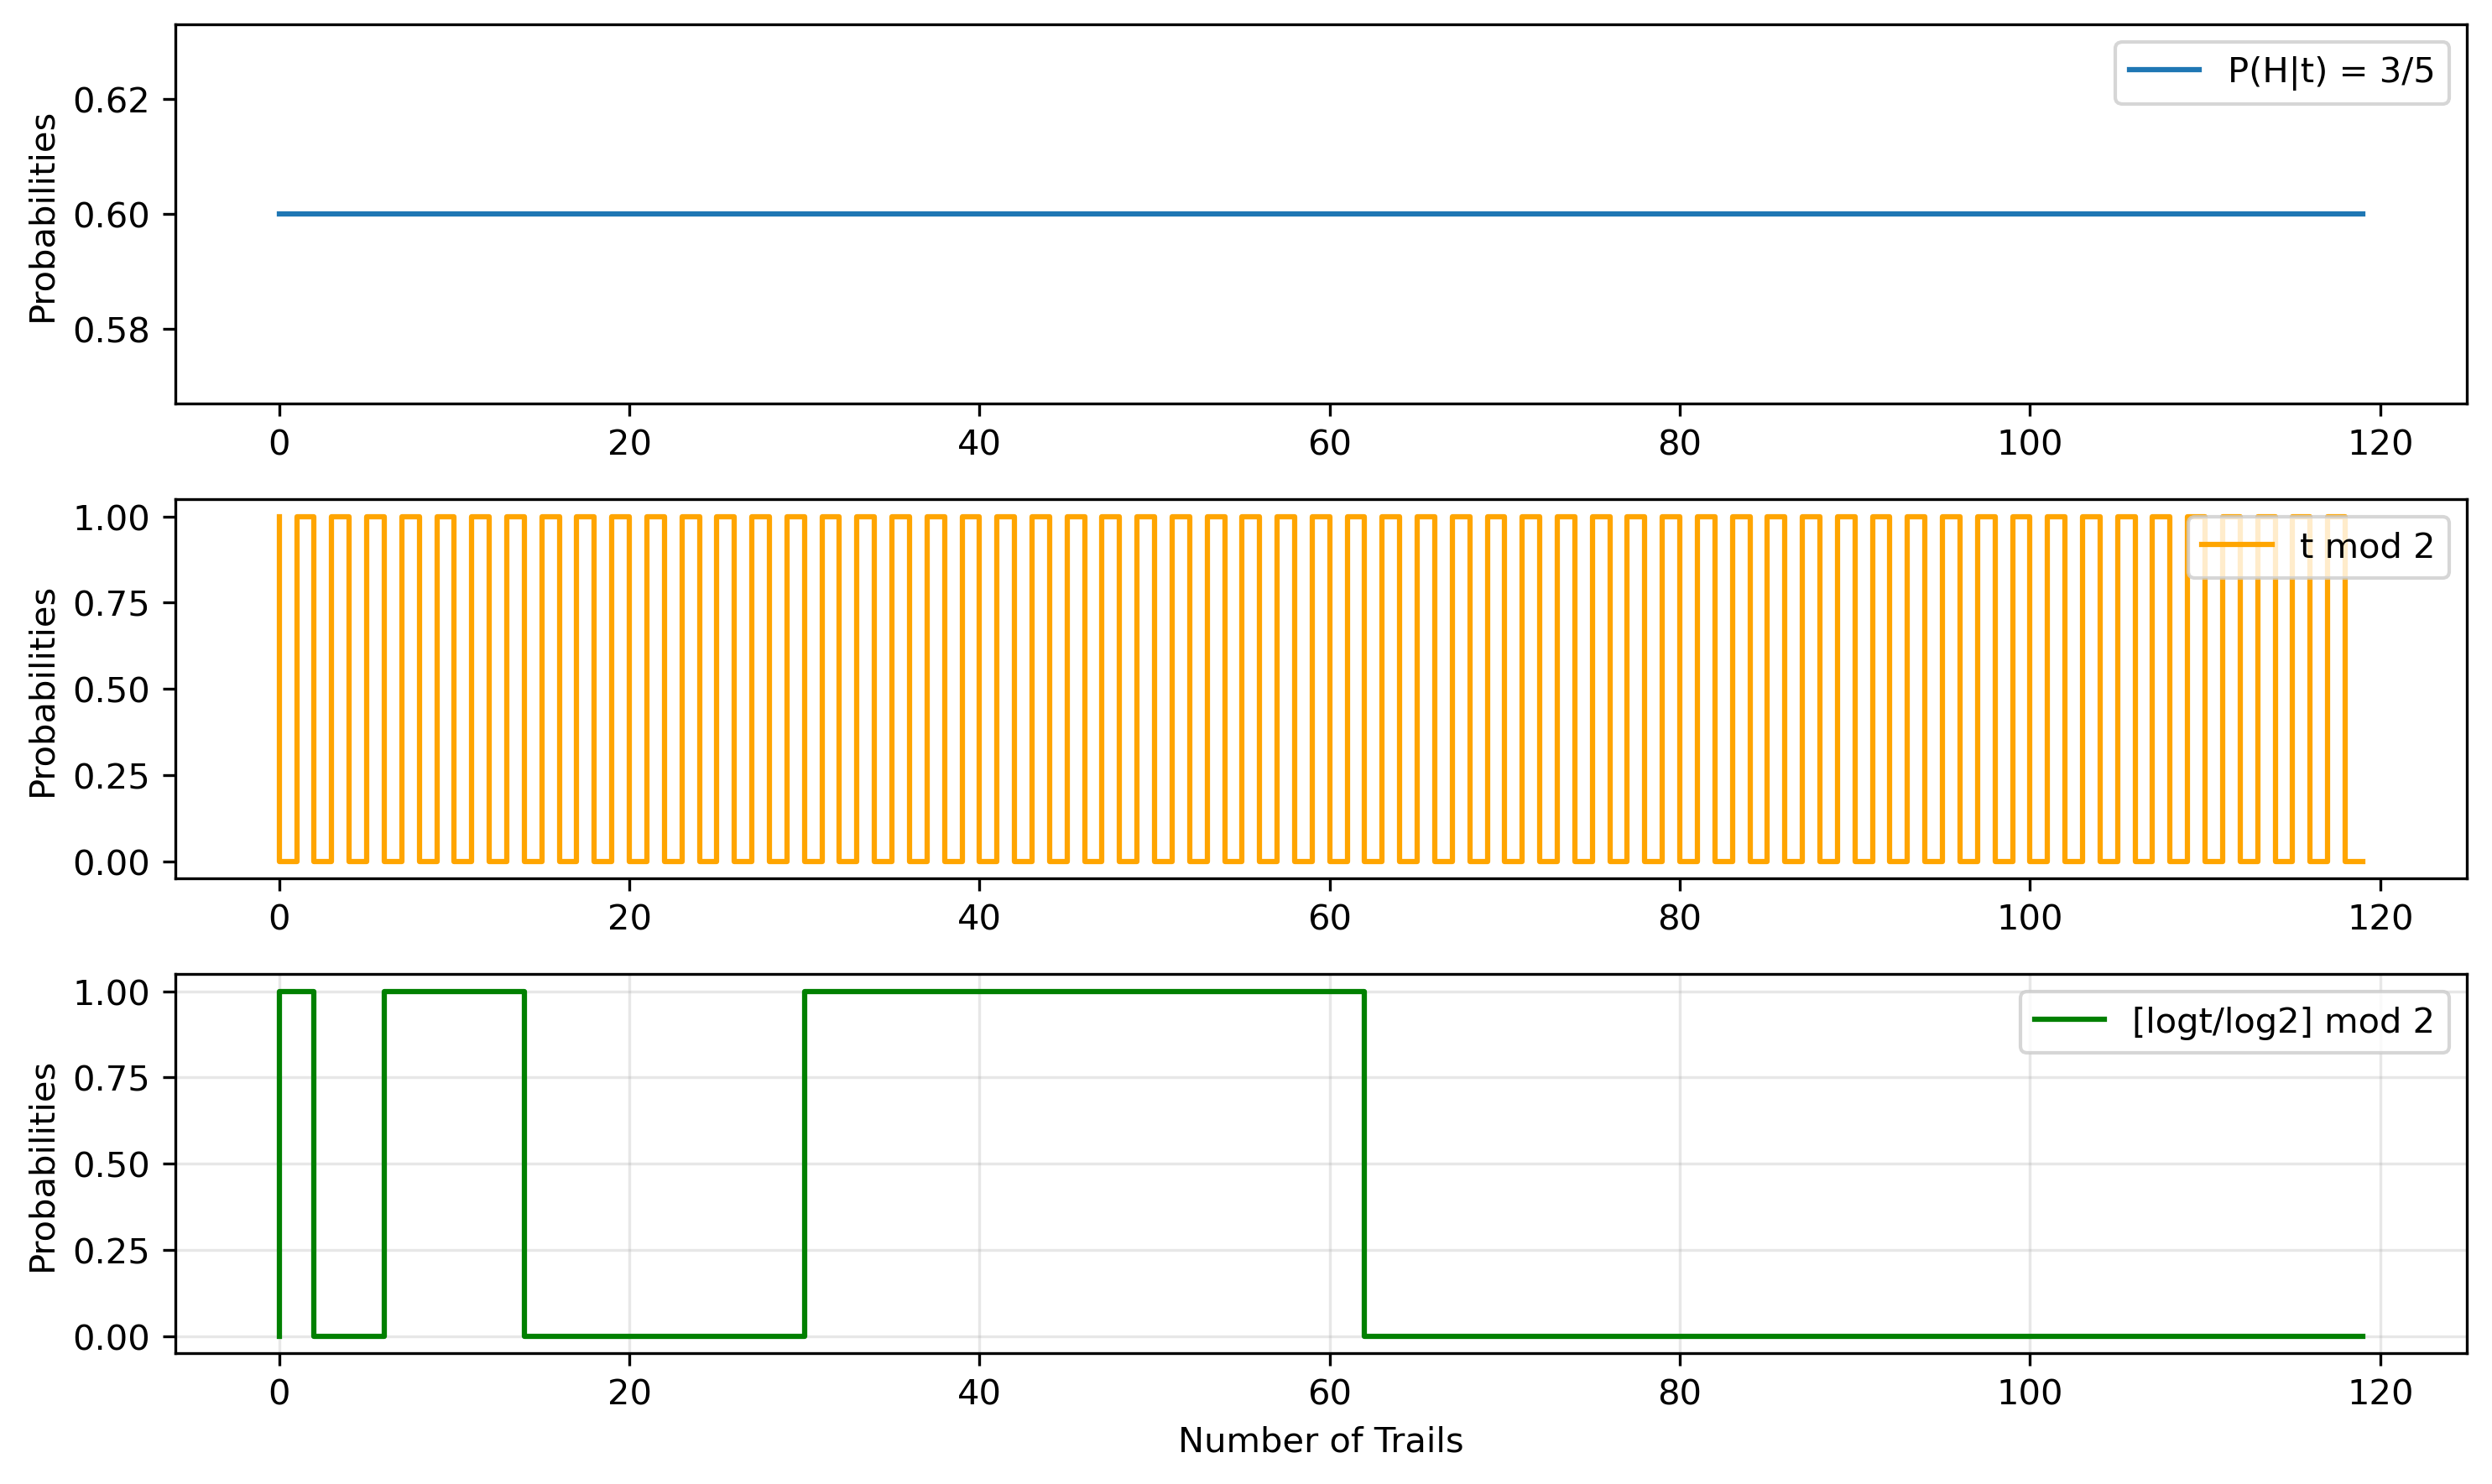

In [12]:
num_rounds = 120
bandit_1 = [3/5 for _ in range(num_rounds)]
bandit_2 = [(i+1)%2 for i in range(num_rounds)]
bandit_3 = [int((np.log(i+1)/np.log(2)) % 2) for i in range(num_rounds)]


fig, axes = plt.subplots(nrows=3, ncols=1, dpi=300)

axes[0].plot(bandit_1, label='P(H|t) = 3/5')
axes[0].set_ylabel('Probabilities')
axes[0].legend()
axes[1].step(range(num_rounds), bandit_2, label='t mod 2', color='orange')
axes[1].set_ylabel('Probabilities')
axes[1].legend()
axes[2].step(range(num_rounds), bandit_3, label='[logt/log2] mod 2', color='g')
axes[2].set_ylabel('Probabilities')
axes[2].legend()
axes[2].set_xlabel('Number of Trails')

plt.grid(True, alpha=0.3)
plt.tight_layout()

### Sample and Payout functions

In [3]:
# Sample & Payout function for P(H|t) = 3/5
def sample_payouts_P1(action, t):
    sample = np.random.binomial(1, 3/5)
    if action == 'H':
        return int(sample == 1)
    elif action == 'T':
        return int(sample == 0)
    else:
        raise ValueError('Invalid action')  

# Sample & Payout function for P(H|t) = t mod 2
def sample_payouts_P2(action, t):
    p_head = int(t % 2)
    if action == 'H':
        return int(p_head == 1)
    elif action == 'T':
        return int(p_head == 0)
    else:
        raise ValueError('Invalid action')  

# Sample & Payout function for P(H|t) = (logt/log2) mod 2
def sample_payouts_P3(action, t):
    p_head = int((np.log(t)/np.log(2)) % 2)
    if action == 'H':
        return int(p_head == 1)
    elif action == 'T':
        return int(p_head == 0)
    else:
        raise ValueError('Invalid action')   

In [99]:
test_p1_head = [sample_payouts_P1('H', _) for _ in range(10)]
test_p1_head

[0, 0, 1, 1, 1, 0, 1, 0, 1, 0]

In [33]:
0 == sample_payouts_P2('H', 44)

True

In [40]:
1 == sample_payouts_P2('H', 53)

True

In [37]:
1 == sample_payouts_P3('T', 100)

True

In [41]:
1 == sample_payouts_P3('H', 43)

True

### Thompson Sampling

In [35]:
actions_code = {
    0: 'H',
    1: 'T'
}

def thompson_step(step, N, mu, mu2, payout_f):
    global actions_code

    # select an action
    # find the action which has been the least tried
    Idx_min = np.argmin(N)
    N_min = N[Idx_min,0]

    if N_min < 12:
        a = Idx_min
    else:
        sig = mu2 - mu**2
        a = np.argmax(mu + sig * np.random.randn(len(mu), 1))

    payout = payout_f(actions_code[a], step)
    # updates statistics
    N[a,0] = N[a,0] + 1
    mu[a,0] = mu[a,0] + (payout-mu[a,0])/N[a,0]
    mu2[a,0] = mu2[a,0] + (payout*payout - mu2[a,0]) / N[a,0]

    return a, payout


In [51]:
f_names = {
    1 : 'P=3/5',
    2 : 'P=t mod 2',
    3 : 'P=[logt/log2] mod 2'
}

Nit = 1000000
d = 2 # H, T
actions = np.zeros(Nit+1) 
# samples = np.zeros(Nit)
payouts = np.zeros(Nit+1)
N = np.zeros((d,1))
mu = np.zeros((d,1))
mu2 = np.zeros((d,1))

for t in range(1, Nit+1):
    at, pt = thompson_step(t, N, mu, mu2, sample_payouts_P3)
    actions[t] = at
    payouts[t] = pt

idx_heads = np.where(actions[1:]==0)[0]
idx_tails = np.where(actions[1:]==1)[0]

plot_name = f_names[3]

In [52]:
mu

array([[0.72130677],
       [0.42482459]])

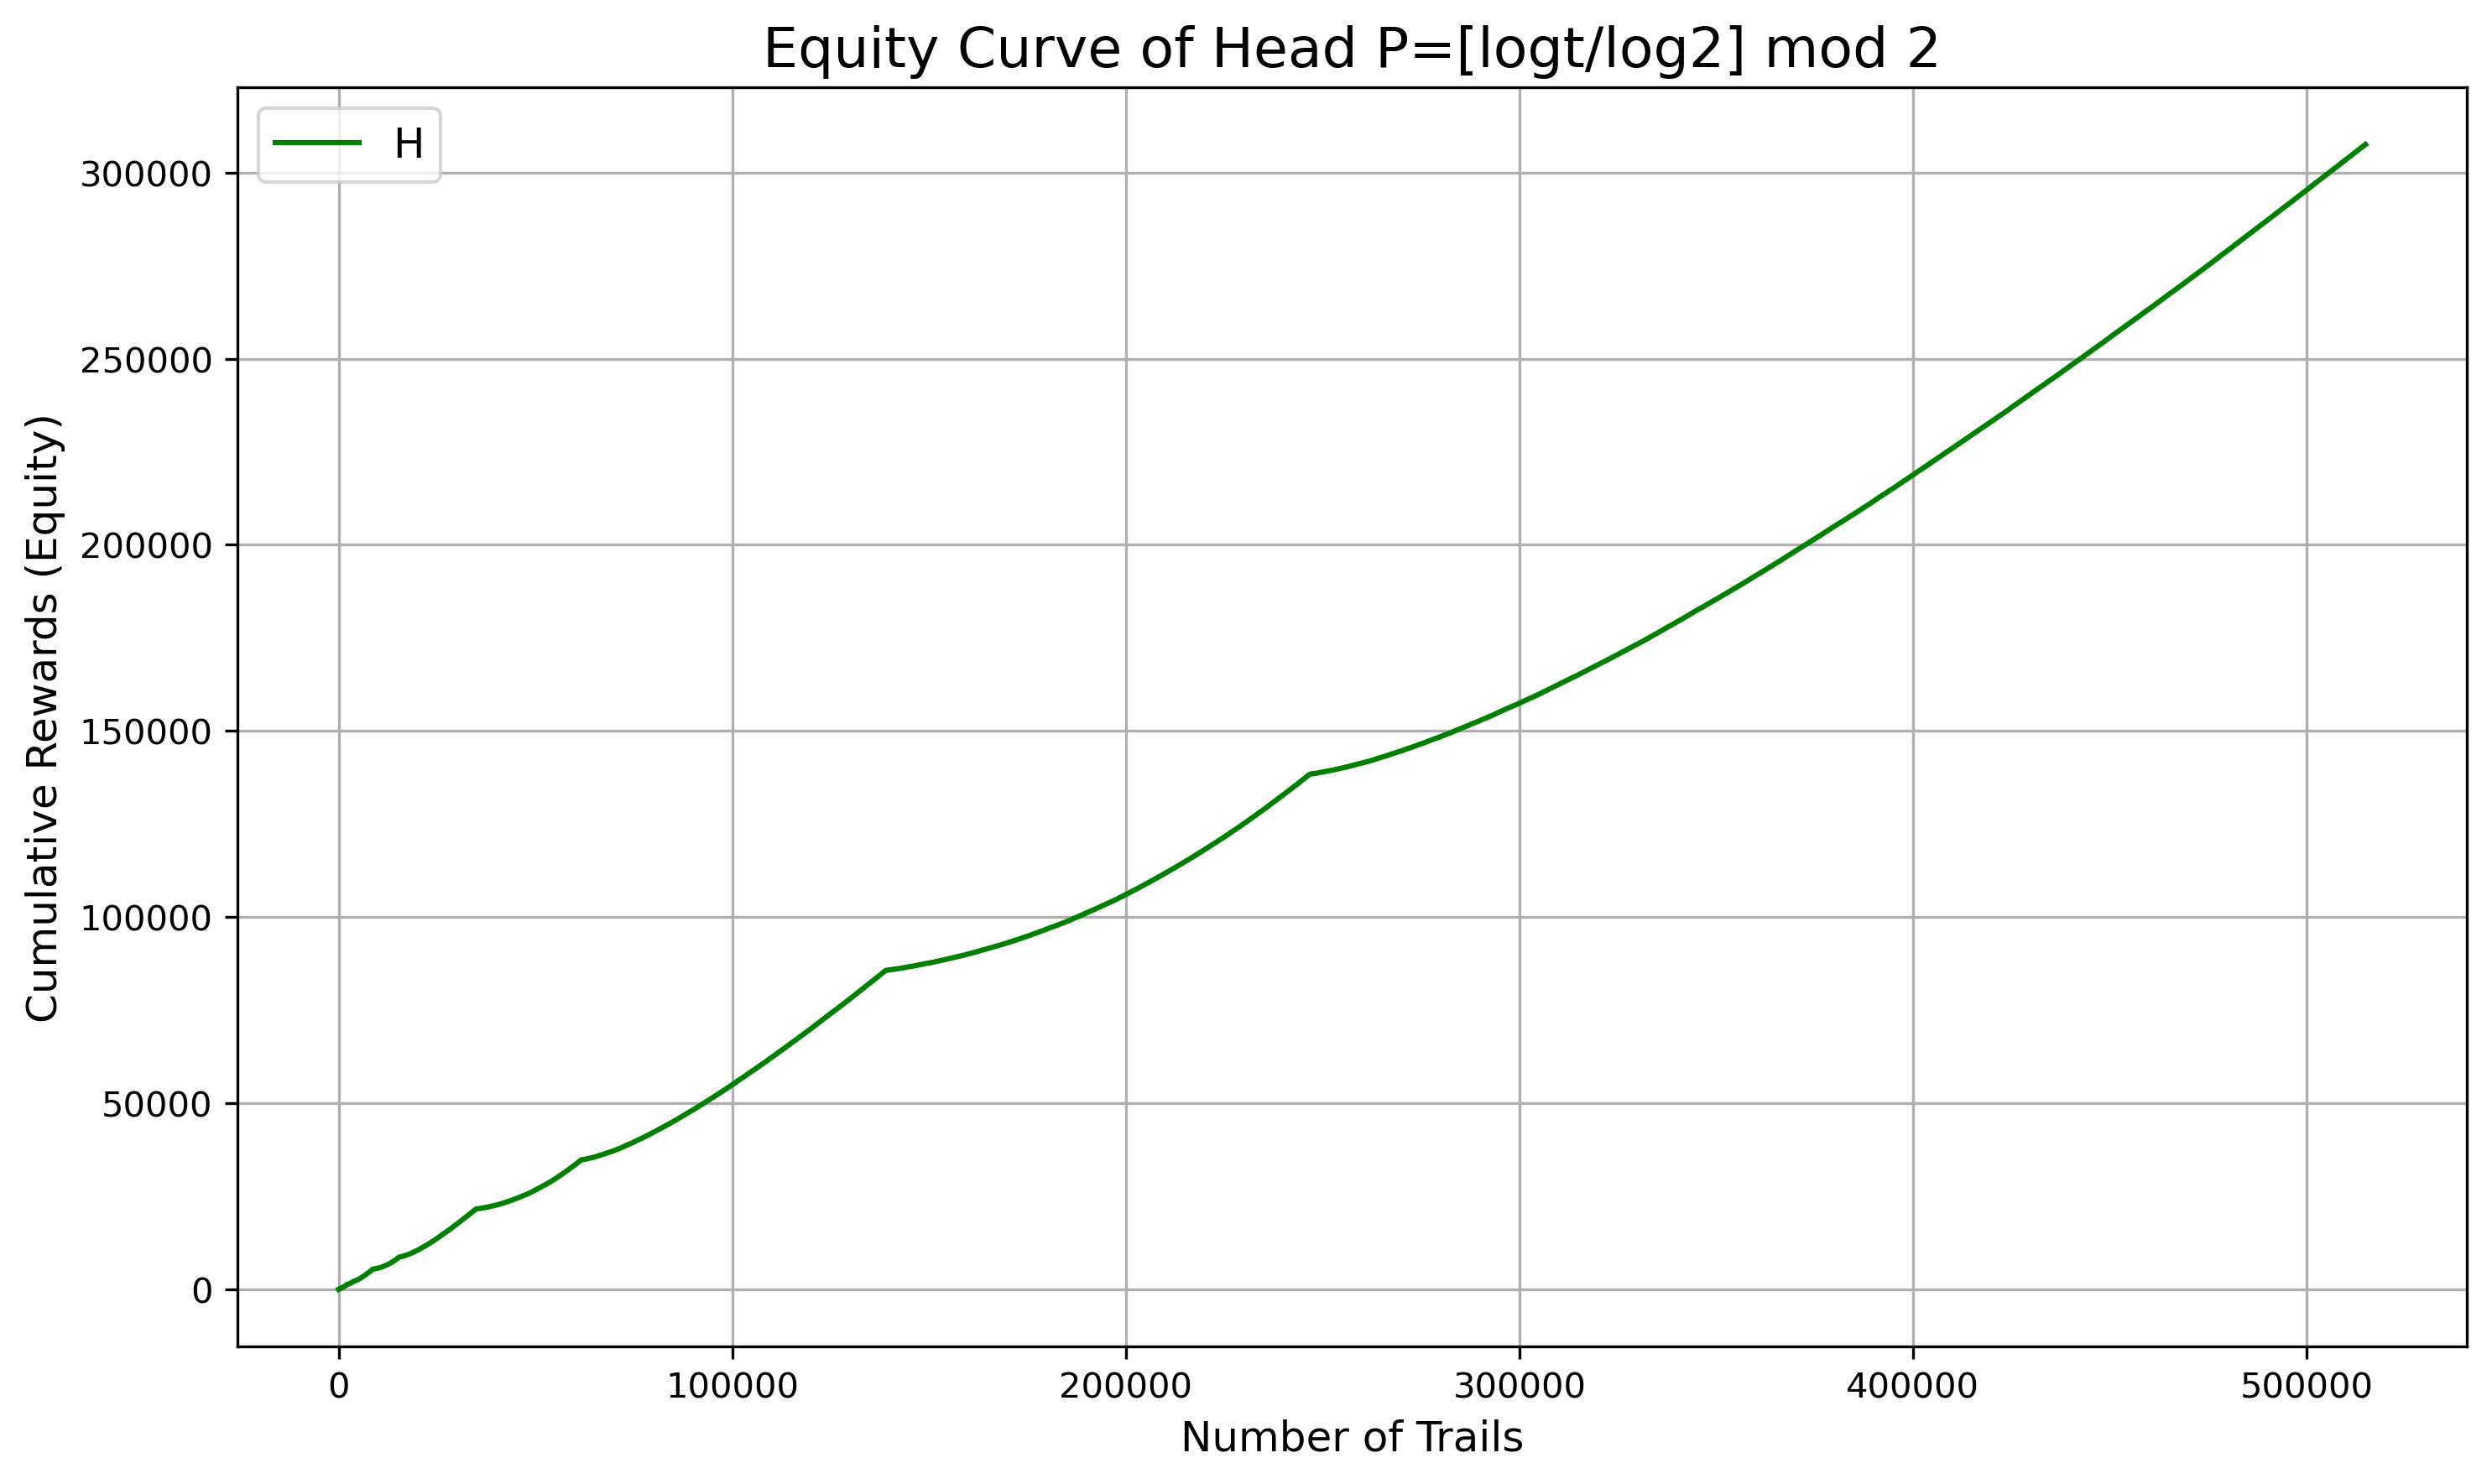

In [47]:
fig, ax = plt.subplots(dpi=300)
ax.plot(np.cumsum(payouts[idx_heads]), label='H', color='g')
ax.set_xlabel('Number of Trails', fontsize=12)
ax.set_ylabel('Cumulative Rewards (Equity)', fontsize=12)
ax.set_title(f'Equity Curve of Head {plot_name}', fontsize=16)
ax.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()


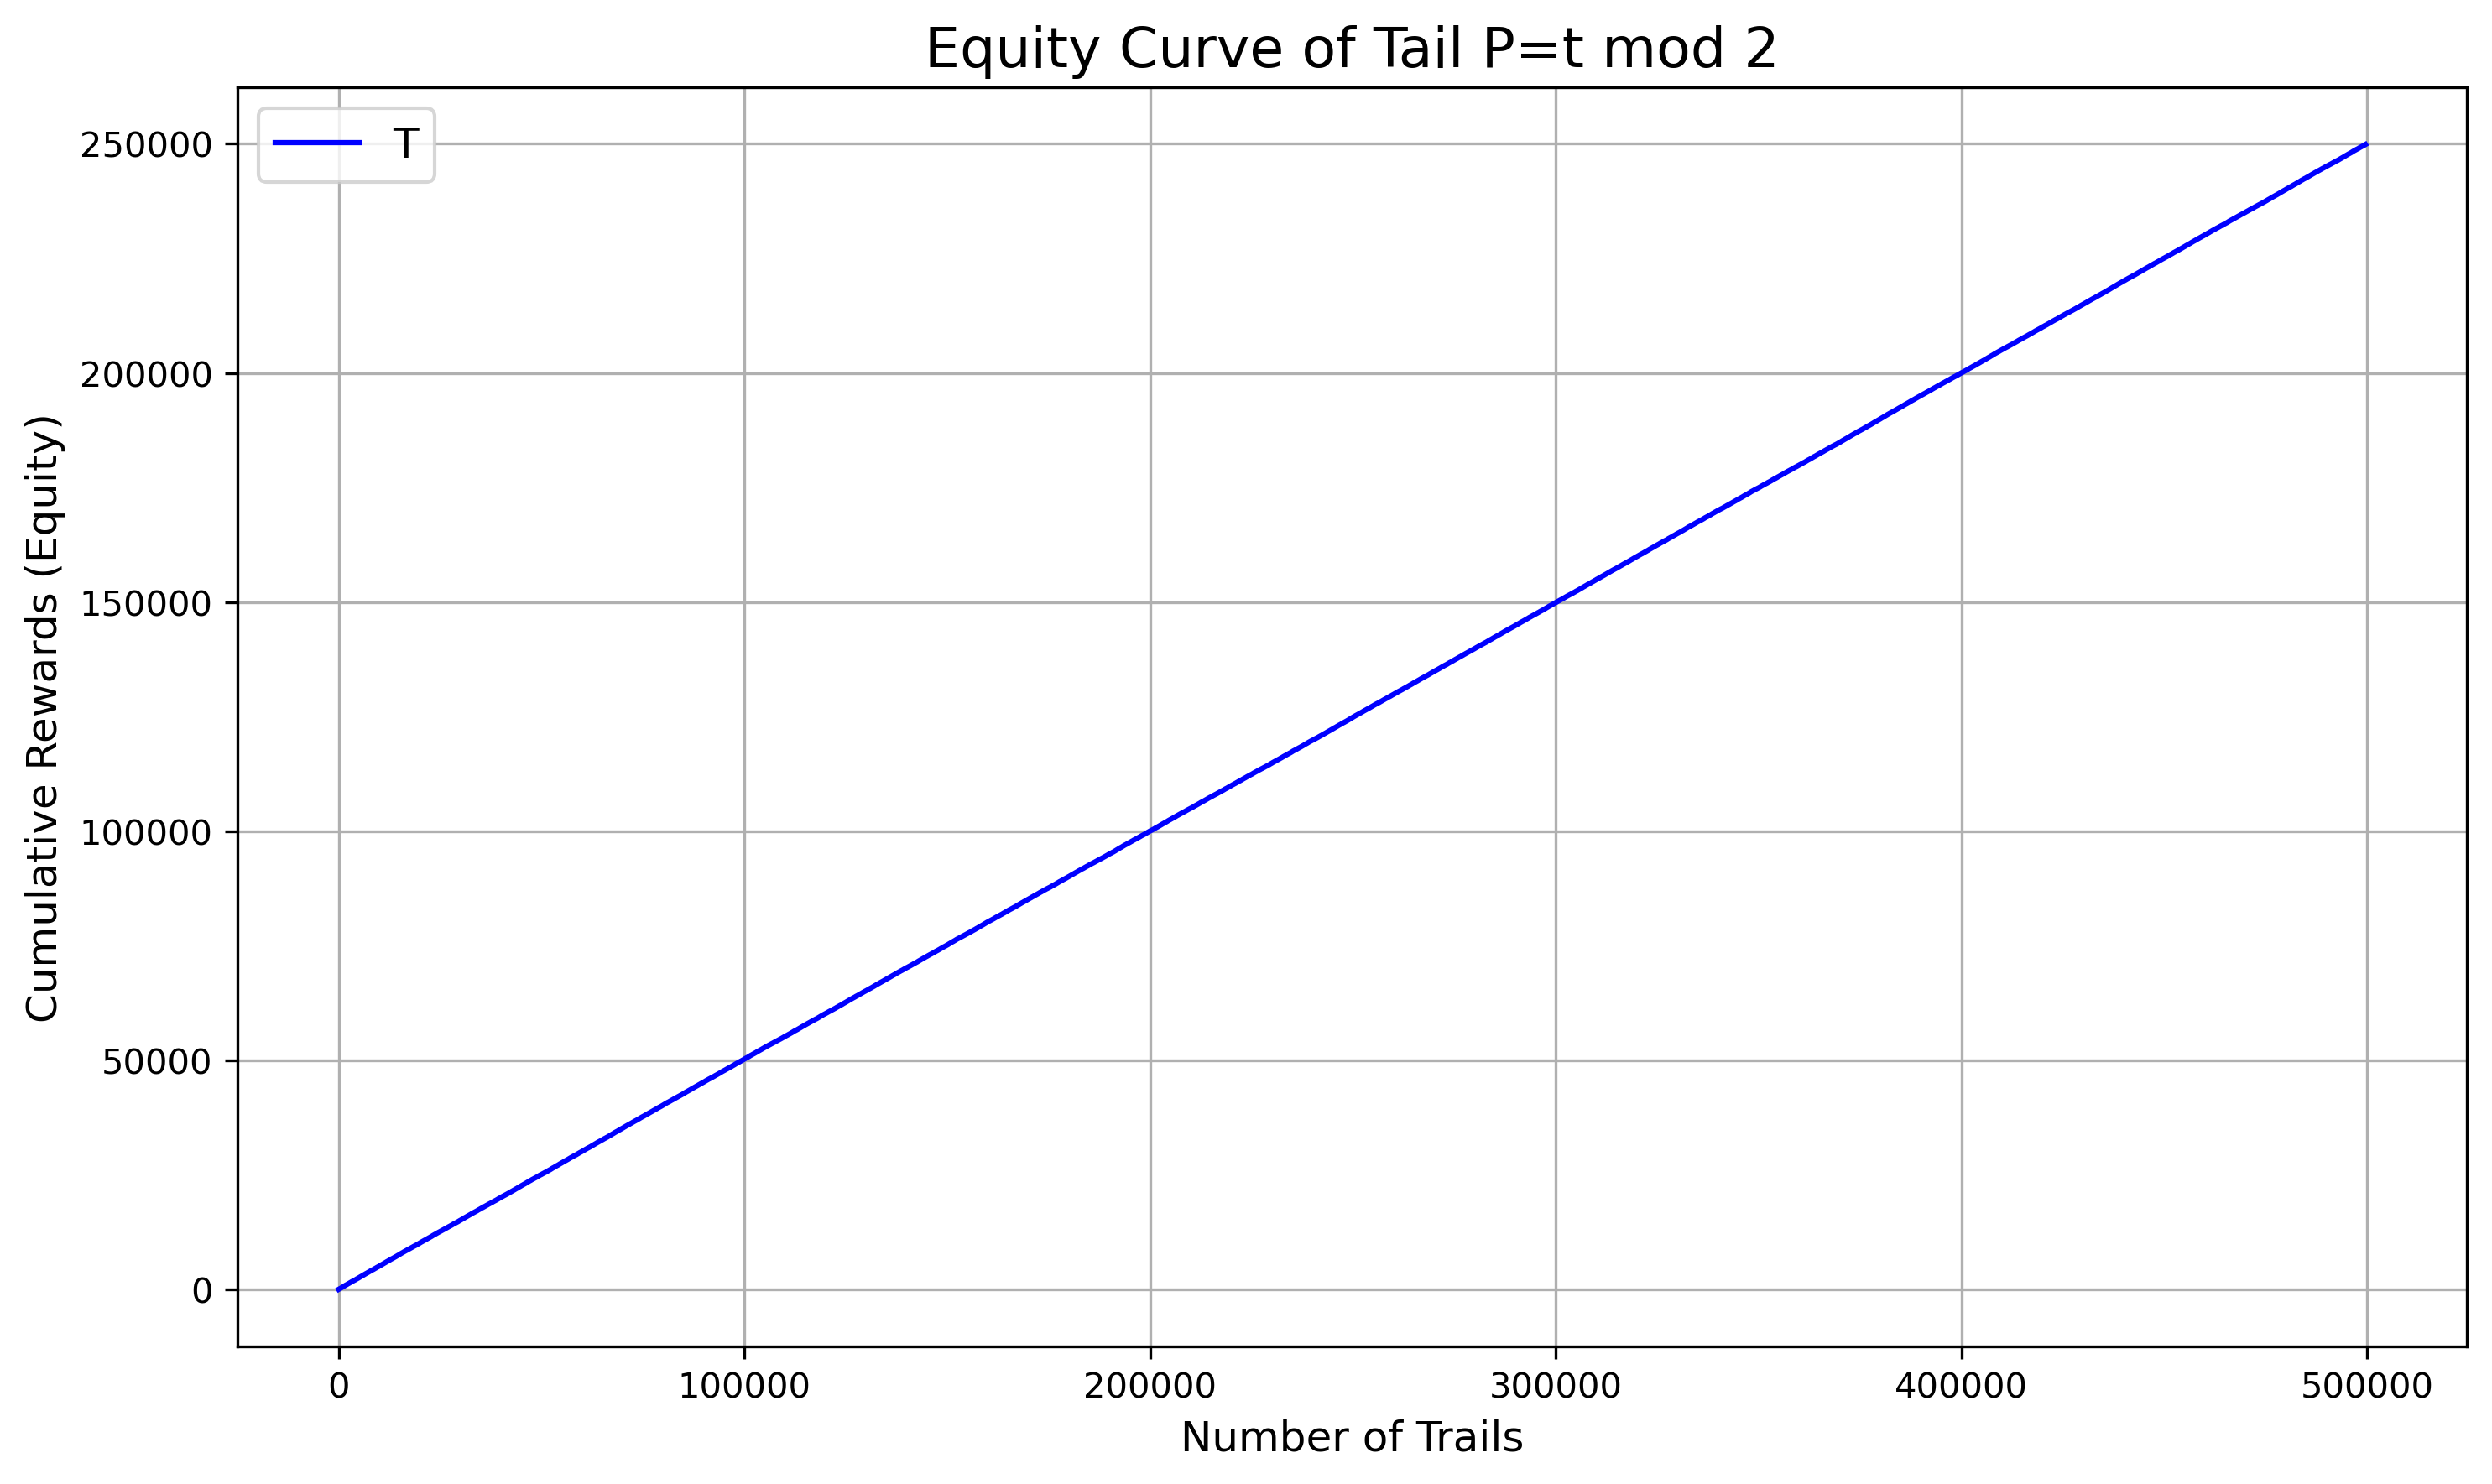

In [42]:
fig, ax = plt.subplots(dpi=300)
ax.plot(np.cumsum(payouts[idx_tails]), label='T', color='b')
ax.set_xlabel('Number of Trails', fontsize=12)
ax.set_ylabel('Cumulative Rewards (Equity)', fontsize=12)
ax.set_title(f'Equity Curve of Tail {plot_name}', fontsize=16)
ax.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()


In [49]:
N

array([[514981.],
       [485019.]])

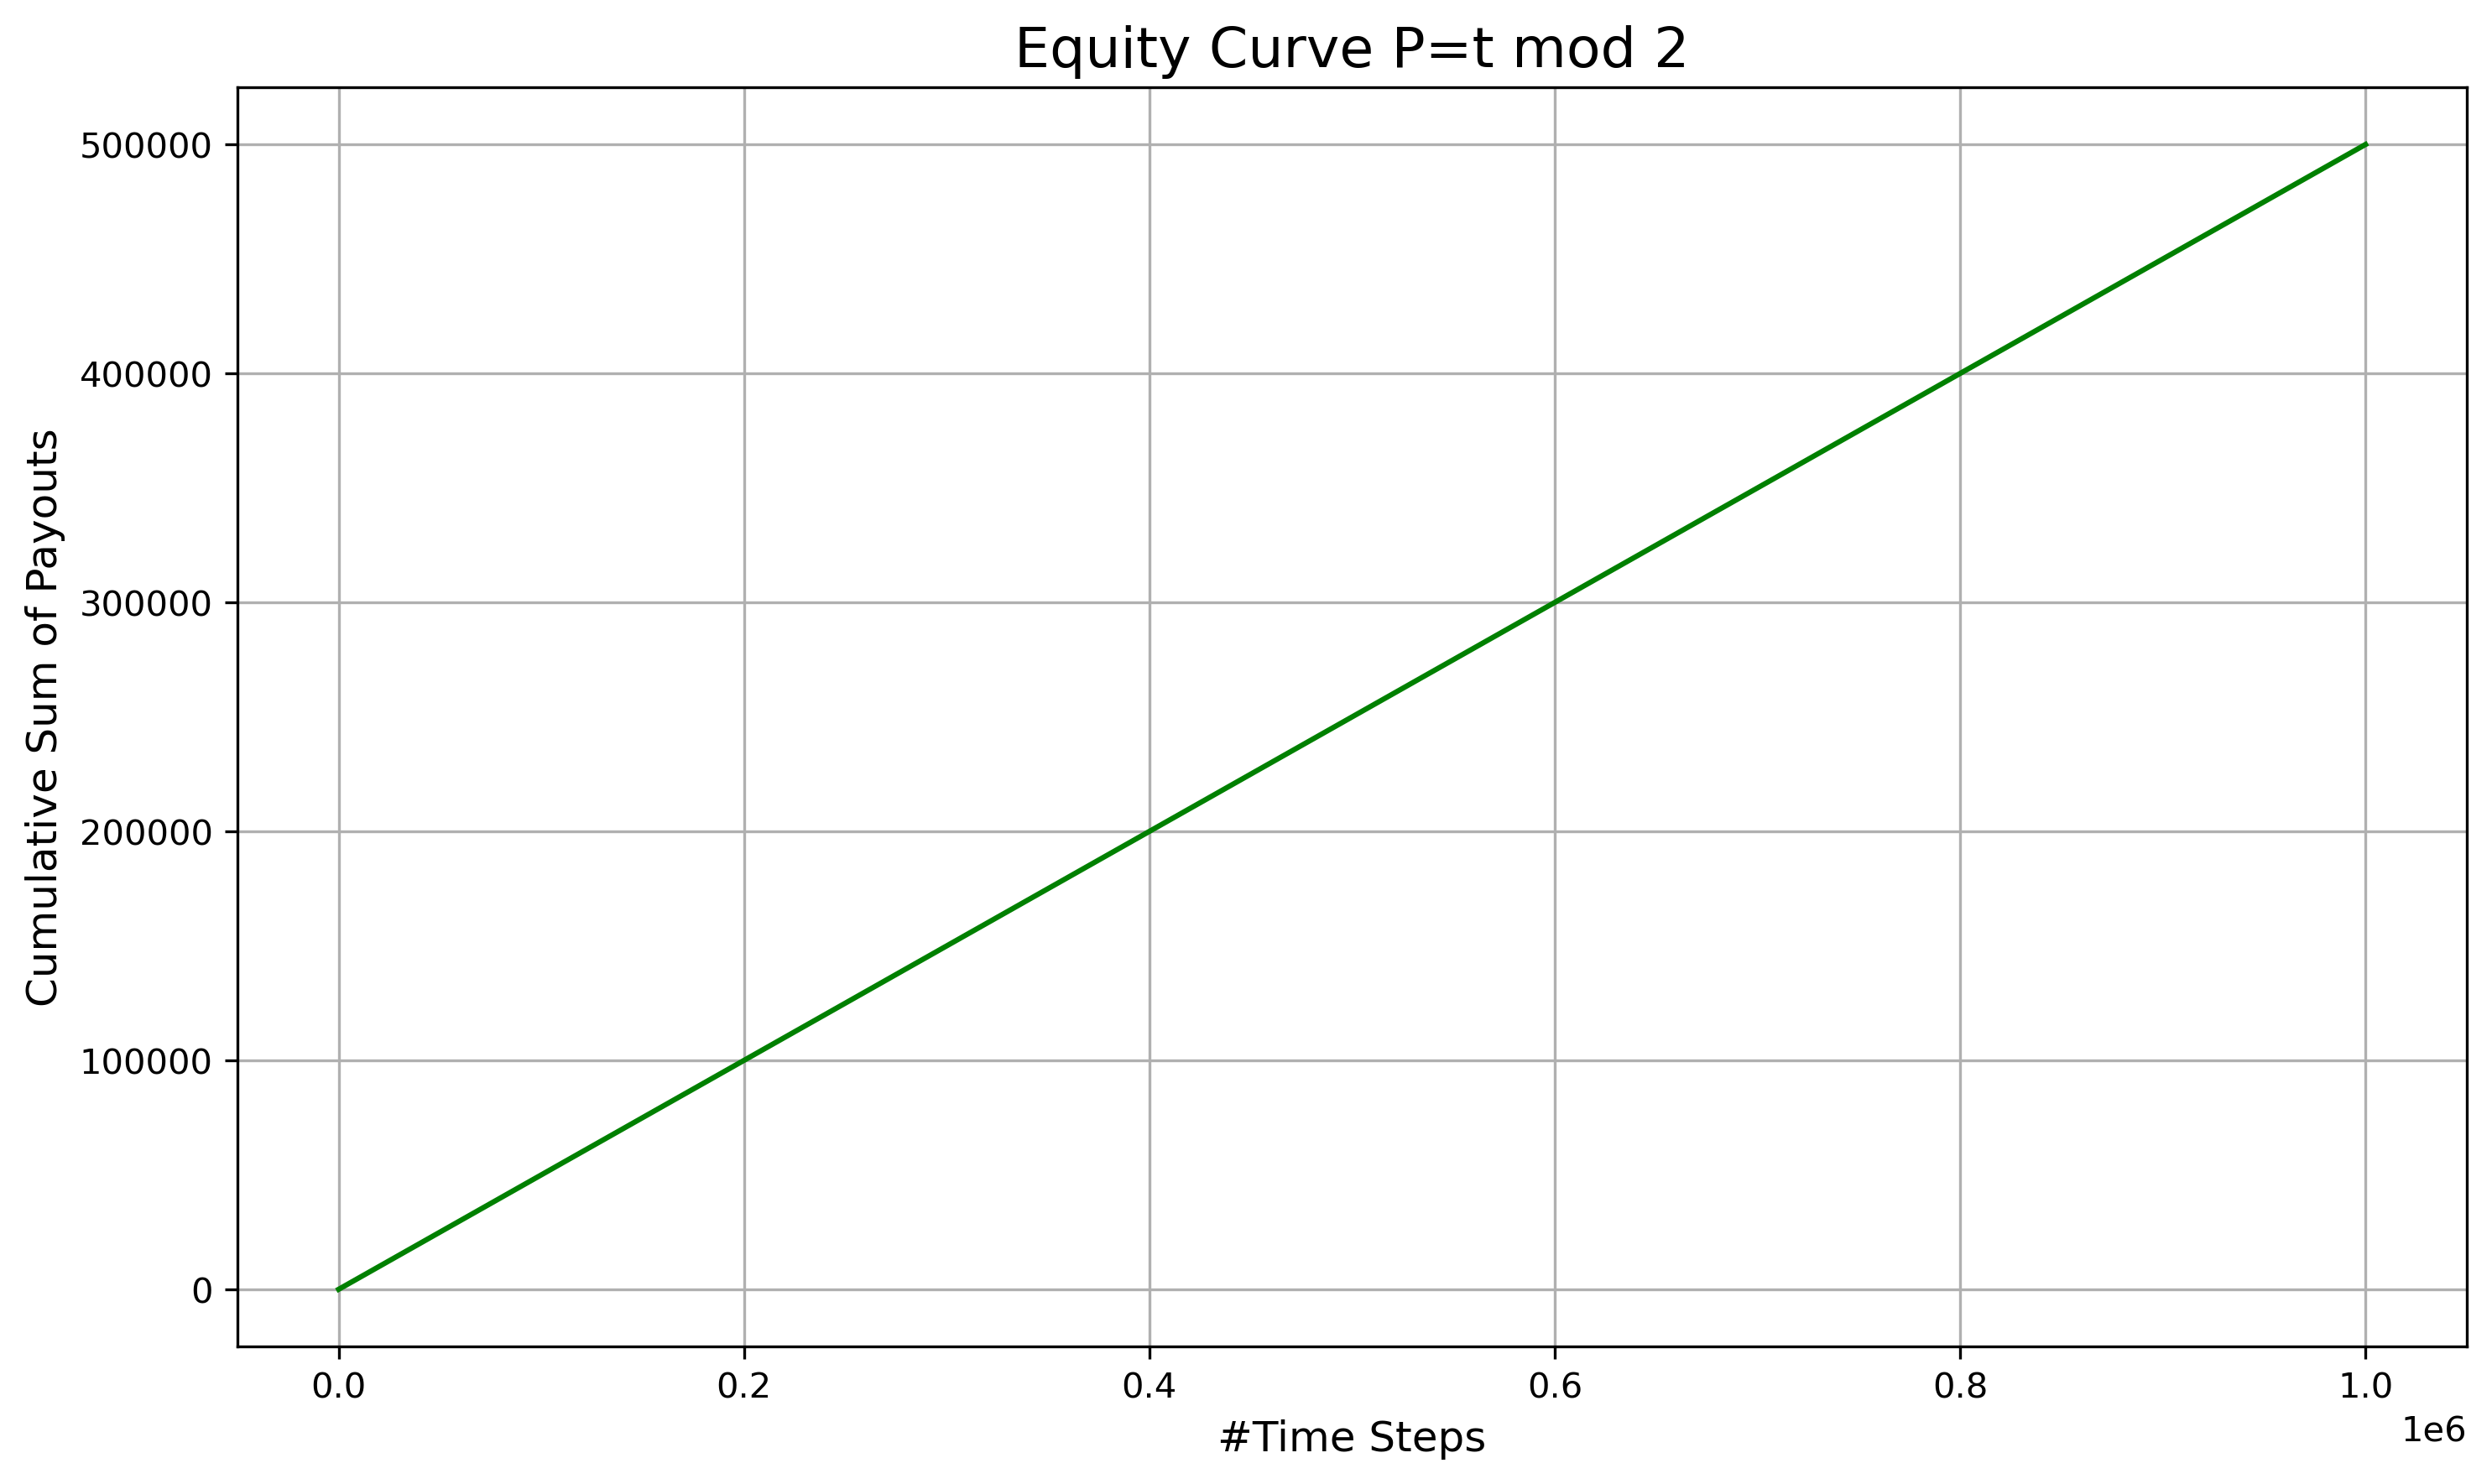

In [32]:
# Calculating the equity curve
equity_curve = np.cumsum(payouts)[1:]

fig, ax = plt.subplots(dpi=300)
ax.plot(equity_curve, color='g')
ax.set_title(f'Equity Curve {plot_name}',fontsize=16)
ax.set_xlabel('#Time Steps', fontsize=12)
ax.set_ylabel('Cumulative Sum of Payouts', fontsize=12)
plt.grid(True)
plt.tight_layout()

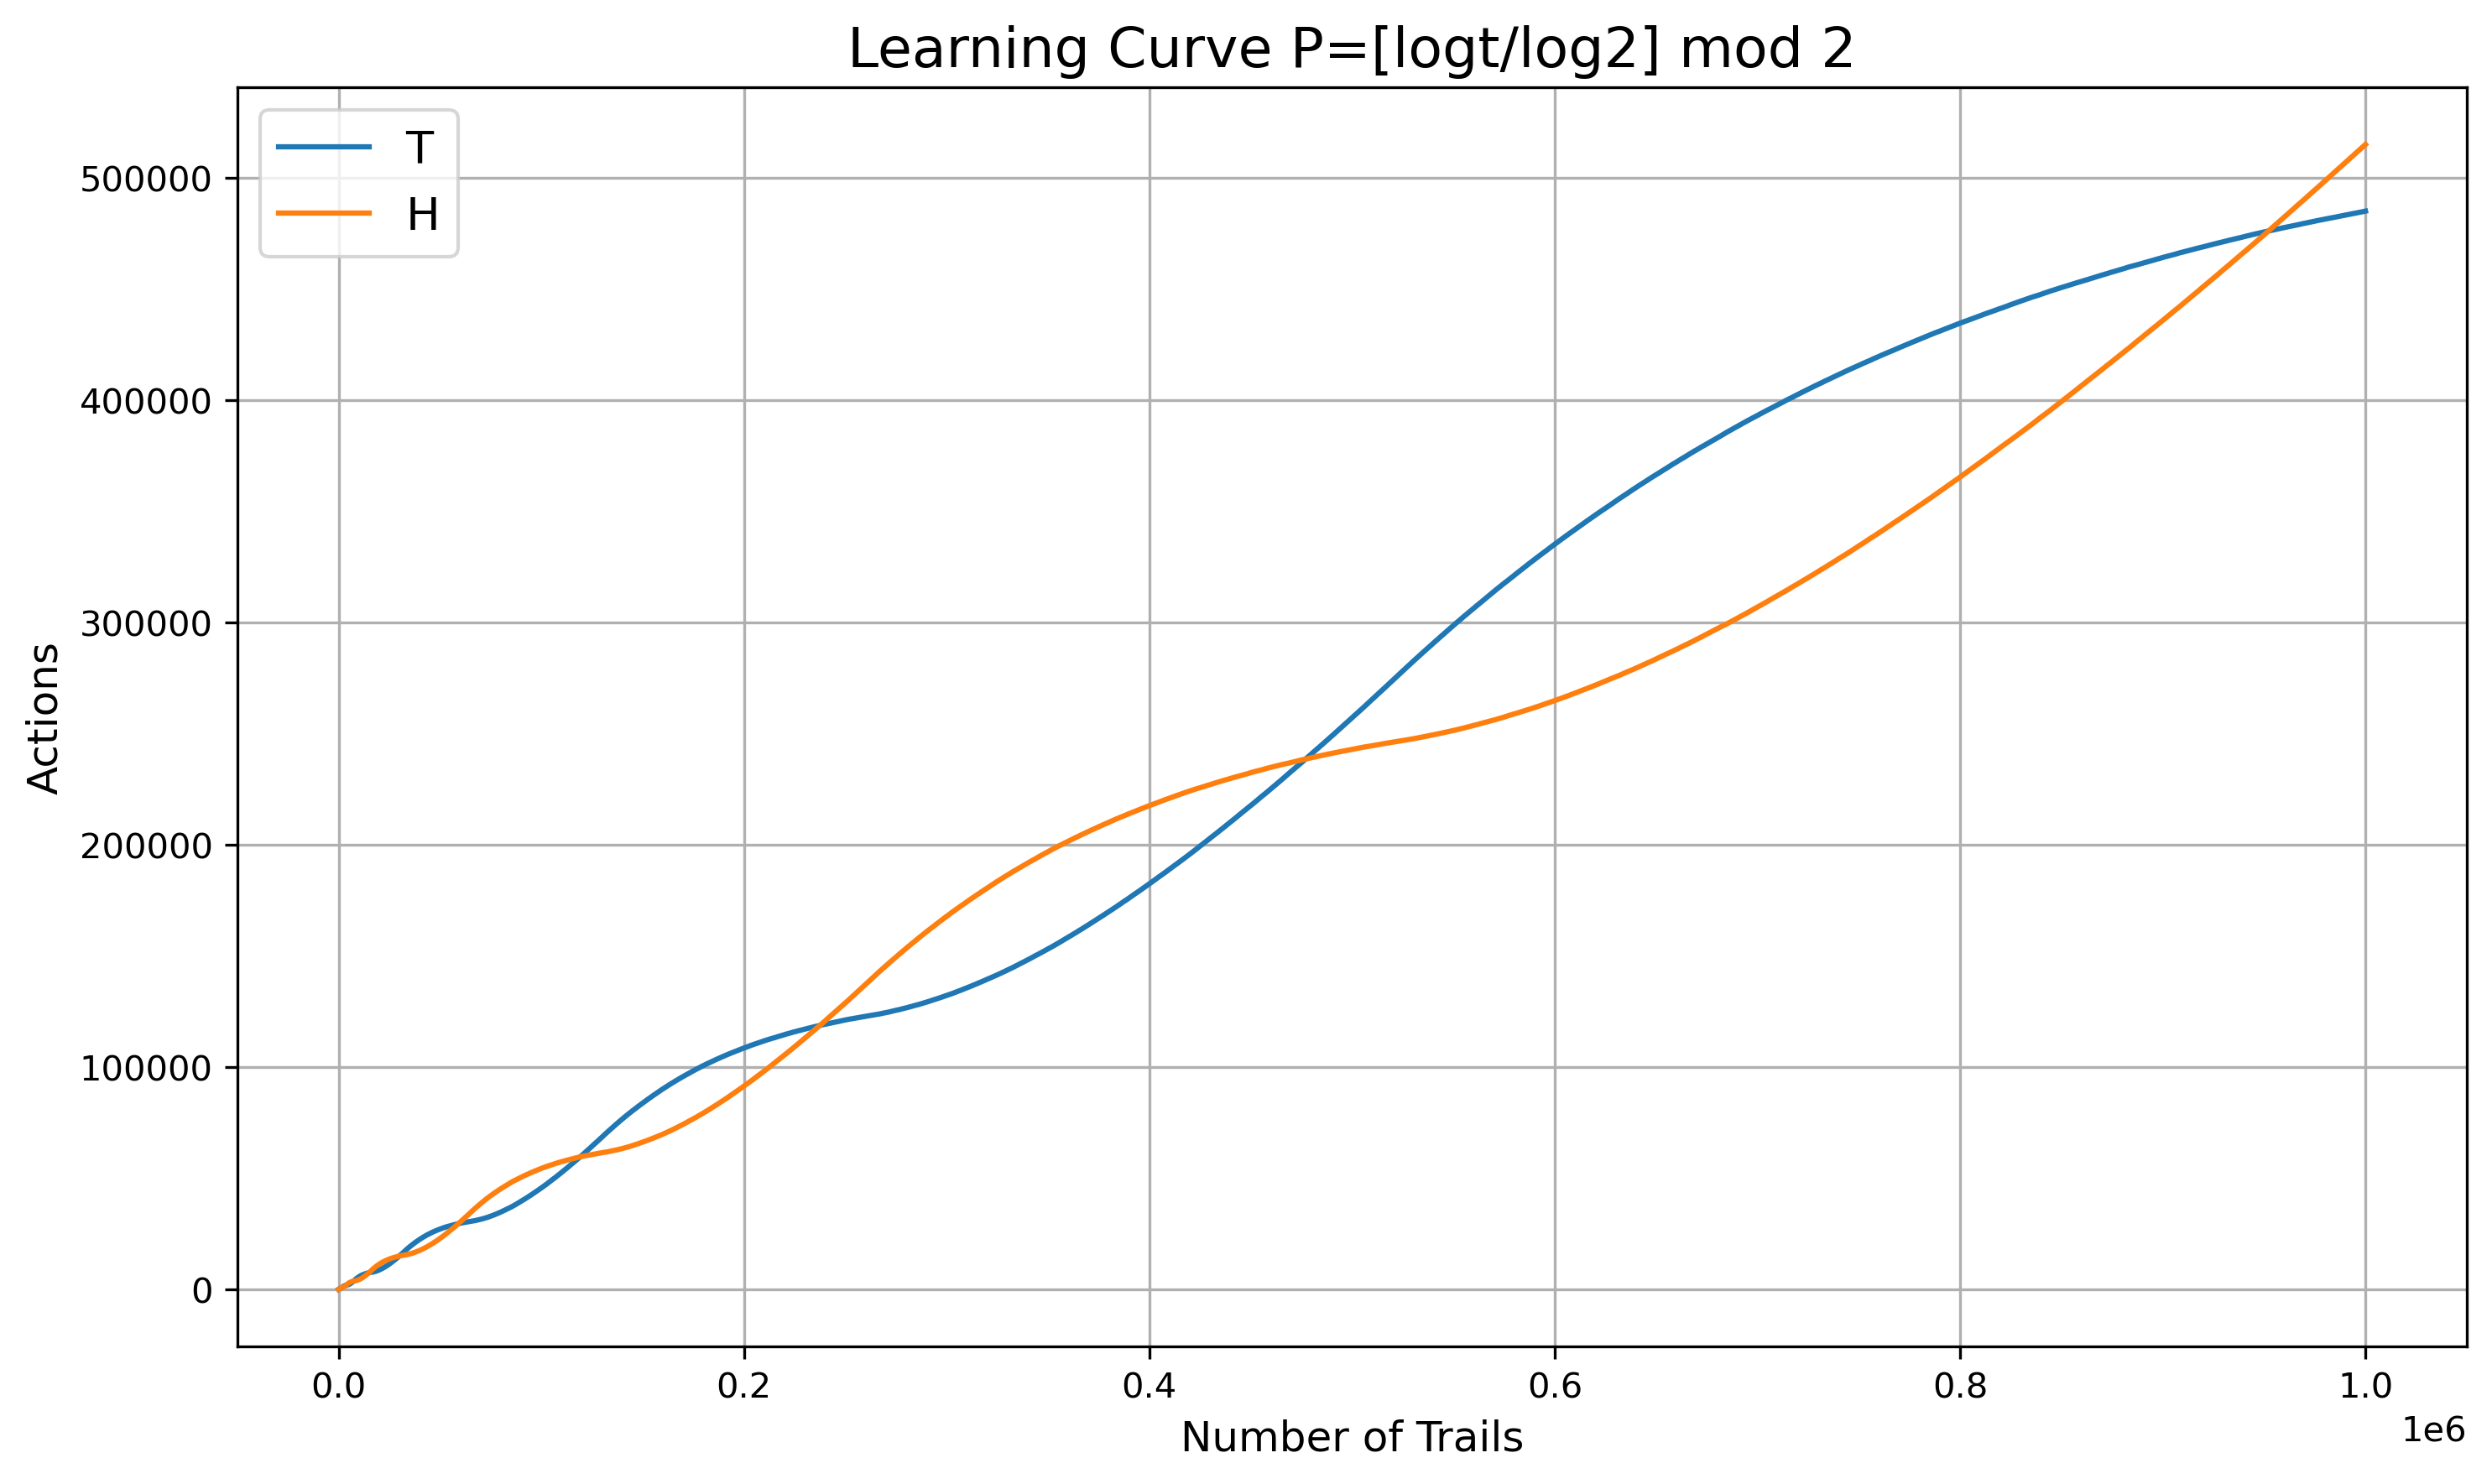

In [48]:
fig, ax = plt.subplots(dpi=300)
# Calculate the cumulative sum of tails (1s) to represent learning over time
cumulative_tails = np.cumsum(actions[1:])
cumulative_heads = np.cumsum([not a for a in actions[1:]])

# # Number of tosses for x-axis
tosses = np.arange(1, len(actions))

# ax.scatter(tosses, actions[1:], color='orange')
ax.plot(cumulative_tails, label='T')
ax.plot(cumulative_heads, label='H')
ax.set_title(f'Learning Curve {plot_name}', fontsize=16)
ax.set_xlabel('Number of Trails', fontsize=12)
ax.set_ylabel('Actions', fontsize=12)
plt.grid(True)
plt.legend(fontsize=13)
plt.tight_layout()